In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from unicodedata import normalize
from sklearn.model_selection import train_test_split
import string
import time
import re

In [ ]:
path = '/train.csv.zip'

In [ ]:
df = pd.read_csv(path)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
grouped = df.groupby("is_duplicate").count()
grouped

,id,qid1,qid2,question1,question2
is_duplicate,,,,,
0,255027,255027,255027,255026,255025
1,149263,149263,149263,149263,149263


In [ ]:
# Process the data file
def process_pairs(line):
#    line = ' '.join(line)
    line = str(line).lower().strip()
    line = normalize('NFD' , line).encode('ascii' , 'ignore')
    line = line.decode('UTF-8')
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ",line)
    line = line.strip()
    return line

In [ ]:
question1 = [process_pairs(sente) for sente in df['question1']]
question2 = [process_pairs(sente) for sente in df['question2']]
y = np.array(df['is_duplicate'])

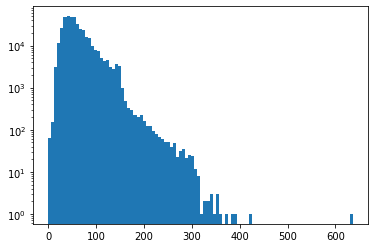

In [ ]:
plt.hist([len(s) for s in question1],log=True, bins=100)
plt.show()

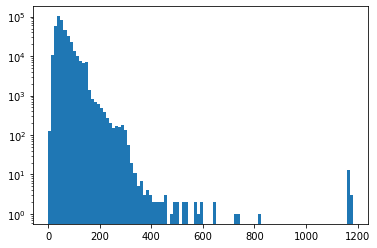

In [ ]:
plt.hist([len(s) for s in question2],log=True, bins=100)
plt.show()

In [ ]:
max_sent_len = max([len(line) for line in np.concatenate((question1,question2))])
print('max sentence length: {}'.format(max_sent_len))
max_sent_len = 200

max sentence length: 1181


In [ ]:
def tokenize(question1, question2):
    combined = question1+question2
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(combined)
    print(len(lang_tokenizer.word_index))

    question1_tensor = lang_tokenizer.texts_to_sequences(question1)
    question1_padded = tf.keras.preprocessing.sequence.pad_sequences(question1_tensor, padding='post', maxlen = max_sent_len)

    question2_tensor = lang_tokenizer.texts_to_sequences(question2)
    question2_padded = tf.keras.preprocessing.sequence.pad_sequences(question2_tensor, padding='post', maxlen = max_sent_len)
    return question1_padded, question2_padded, lang_tokenizer

In [ ]:
question1_padded, question2_padded, lang_tokenizer = tokenize(question1, question2)

79556


In [ ]:
max_length_targ, max_length_inp = question1_padded.shape[1], question2_padded.shape[1]
max_length_targ, max_length_inp

(200, 200)

In [ ]:
vocab_size = len(lang_tokenizer.word_index)+1

In [ ]:
train_x1, test_x1, train_x2, test_x2, train_y, test_y = train_test_split(question1_padded, question2_padded, y, test_size=0.8)
train_x1.shape, test_x1.shape, train_x2.shape, test_x2.shape, train_y.shape, test_y.shape

((80858, 200), (323432, 200), (80858, 200), (323432, 200), (80858,), (323432,))

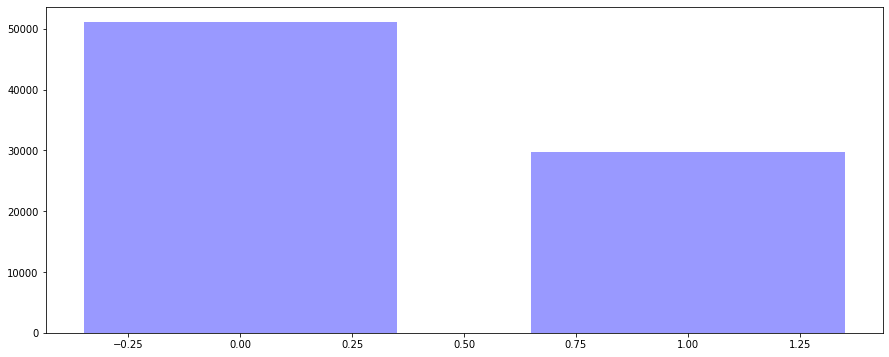

In [ ]:
import collections
y_trainx =np.reshape(train_y, (train_y.shape[0]))
np.unique(y_trainx)
elements_count = collections.Counter(y_trainx.tolist())
plt.figure(figsize =(15, 6))
plt.bar(elements_count.keys(),elements_count.values(), color = 'b', width = 0.7, alpha =0.4)
plt.show()

In [ ]:
BUFFER_SIZE = train_x1.shape[0]
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices((train_x1, train_x2, train_y)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

BUFFER_SIZE_TEST = test_x1.shape[0]
dataset_test = tf.data.Dataset.from_tensor_slices((test_x1, test_x2, test_y)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.wq = tf.keras.layers.Dense(self.head_dim)
        self.wk = tf.keras.layers.Dense(self.head_dim)
        self.wv = tf.keras.layers.Dense(self.head_dim)
        self.dense = tf.keras.layers.Dense(self.embed_size)


    def call(self, v, k, q, mask):
        # Get number of training examples
        batch_size = q.shape[0]

        seq_len_v, seq_len_k, seq_len_q = v.shape[1], k.shape[1], q.shape[1]


        # Split the embedding into self.heads different pieces
        v = tf.reshape(v,(batch_size,seq_len_v, self.heads, self.head_dim))
        k = tf.reshape(k,(batch_size,seq_len_k, self.heads, self.head_dim))
        q = tf.reshape(q,(batch_size,seq_len_q, self.heads, self.head_dim))


        values = self.wv(v)  # (batch_size, value_len, heads, head_dim)
        keys = self.wk(k)  # (batch_size, key_len, heads, head_dim)
        queries = self.wq(q)  # (batch_size, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example

        attention = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        # queries shape: (batch_size, seq_len_q, heads, heads_dim),
        # keys shape: (batch_size, seq_len_k, heads, heads_dim)
        # attention: (batch_size, heads, seq_len_q, seq_len_k)

         # scale matmul_qk
        dk = tf.cast(tf.shape(keys)[1], tf.float32)
        scaled_attention_logits = attention / tf.math.sqrt(dk)

        # Mask padded indices so their weights become 0

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # attention shape: (batch_size, heads, seq_len_q, seq_len_k)



        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (batch_size, seq_len_q, -1))
        # attention shape: (batch_size, heads, seq_len_q, key_len)
        # values shape: (batch_size, seq_len_v, heads, heads_dim)
        # out after matrix multiply: (batch_size, seq_len_q, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.dense(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out, attention_weights

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, embed_size, heads, forward_expansion, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.self_attens= SelfAttention(embed_size, heads)
    self.ffn = tf.keras.Sequential([
      tf.keras.layers.Dense(forward_expansion, activation='relu'),  # (batch_size, seq_len, forward_expansion)
      tf.keras.layers.Dense(embed_size)  # (batch_size, seq_len, d_model)
       ])

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.self_attens(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embed_size,  heads, forward_expansion, input_vocab_size, max_length, rate=0.1):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.max_length = max_length
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, embed_size)

        self.Layerss =[EncoderLayer(embed_size, heads, forward_expansion, rate)
                       for _ in range(self.num_layers)]
                      

        self.dropout = tf.keras.layers.Dropout(rate)

    def positional_encoding(self):

        pos = np.arange(self.max_length)[:, np.newaxis]
        i = np.arange(self.embed_size)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(self.embed_size))

        angle_rads = pos * angle_rates

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
                                                         
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
        x += self.positional_encoding()[:, :seq_len, :]


        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
           x = self.Layerss[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
class Similarity(tf.keras.Model):
    def __init__(self, num_layers, embed_size, heads, forward_expansion, input_vocab_size, max_length, rate):
        super(Similarity, self).__init__()
        self.encoder = Encoder(num_layers, embed_size, heads, forward_expansion,input_vocab_size, max_length, rate)
        self.last_layer = tf.keras.Sequential([
#          tf.keras.layers.Dense(512, activation='relu'),  # (batch_size, seq_len, forward_expansion)
          tf.keras.layers.Dense(256, activation='relu'),  # (batch_size, seq_len, d_model)
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(2)
          ])
    def create_masks(self, inp):
      # Encoder padding mask
        return create_padding_mask(inp)

    def call(self, x, training):
        x1, x2 = x
        mask1 = self.create_masks(x1)
        mask2 = self.create_masks(x2)
        out_layer1 = self.encoder(x1, training, mask1)
        out_layer2 = self.encoder(x2, training, mask2)
        out_layer1 = tf.keras.layers.Flatten()(out_layer1)
        out_layer2 = tf.keras.layers.Flatten()(out_layer2)
        prev = tf.concat([out_layer1, out_layer2], axis=1)
        output = self.last_layer(prev)

        return output

In [ ]:
num_layers = 4
embed_size = 64
heads = 4
forward_expansion  = embed_size*2
input_vocab_size = vocab_size
max_length = 10000 
rate = 0.1

In [ ]:
model=Similarity(num_layers, embed_size, heads, forward_expansion, input_vocab_size, max_length, rate)

In [ ]:
for train_x1, train_x2, _ in dataset:
    outputx = model((train_x1, train_x2), training=False)
    print(outputx.shape)
    break

(128, 2)


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(inp1, inp2, tar):
  with tf.GradientTape() as tape:
    logits = model((inp1,inp2), True)
    loss = loss_object(tar, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_accuracy.update_state(tar, logits)
  return loss

In [ ]:
import time
EPOCHS = 100
history = {
  "epoch": [],
  "loss": [],
  "Accuracy" :[]
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  # TRAIN LOOP
  for (batch, (inp1, inp2, tar)) in enumerate(dataset):
      batch_loss = train_step(inp1, inp2,tar)
      total_loss = total_loss + batch_loss

  if (epoch+1) % 1 == 0: 
        history['epoch'].append(epoch)
        history['loss'].append(total_loss/(batch+1))
        history['Accuracy'].append(train_accuracy.result())
        print(f'Epoch {epoch+1}, Loss: {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}') 
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  train_accuracy.reset_states()

Epoch 1, Loss: 0.6382, Accuracy: 0.6292
Time taken for 1 epoch: 81.53 secs

Epoch 2, Loss: 0.6163, Accuracy: 0.6458
Time taken for 1 epoch: 74.45 secs

Epoch 3, Loss: 0.5982, Accuracy: 0.6707
Time taken for 1 epoch: 74.45 secs

Epoch 4, Loss: 0.5793, Accuracy: 0.6881
Time taken for 1 epoch: 74.45 secs

Epoch 5, Loss: 0.5657, Accuracy: 0.7000
Time taken for 1 epoch: 74.43 secs

Epoch 6, Loss: 0.5534, Accuracy: 0.7105
Time taken for 1 epoch: 74.43 secs

Epoch 7, Loss: 0.5442, Accuracy: 0.7191
Time taken for 1 epoch: 74.43 secs

Epoch 8, Loss: 0.5385, Accuracy: 0.7231
Time taken for 1 epoch: 74.44 secs

Epoch 9, Loss: 0.5309, Accuracy: 0.7286
Time taken for 1 epoch: 74.44 secs

Epoch 10, Loss: 0.5256, Accuracy: 0.7339
Time taken for 1 epoch: 74.45 secs

Epoch 11, Loss: 0.5179, Accuracy: 0.7384
Time taken for 1 epoch: 74.44 secs

Epoch 12, Loss: 0.5134, Accuracy: 0.7417
Time taken for 1 epoch: 74.46 secs

Epoch 13, Loss: 0.5060, Accuracy: 0.7465
Time taken for 1 epoch: 74.45 secs

Epoch 14

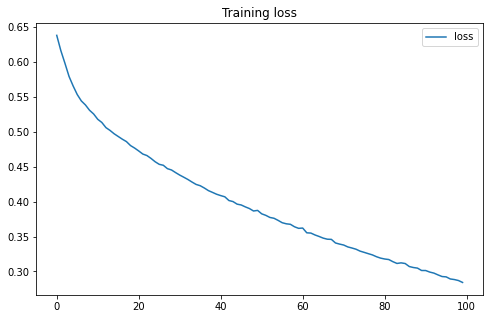

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["epoch"],history["loss"], label='loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

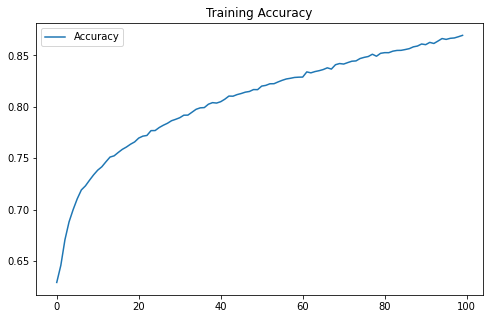

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["epoch"],history["Accuracy"], label='Accuracy')
plt.title('Training Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
def evaluate(inp1,inp2):
    logits = model((inp1,inp2), False)
    predicted_id = tf.argmax(logits, axis=-1)
    return logits, predicted_id

In [ ]:
start = time.time()
for (batch, (inp1,inp2, tar)) in enumerate(dataset_test):
    logits,_ = evaluate(inp1,inp2)
    test_accuracy.update_state(tar, logits)
print('Accuracy of model on Test : ', test_accuracy.result().numpy())
print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Accuracy of model on Test :  0.7436184
Time taken for 1 epoch: 283.53 secs

